In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('atlantic.csv')

###cleaning data###
df = df[df.iloc[:,10]!=-999]
df['Latitude'] = df['Latitude'].str.replace('[a-zA-Z]','')
df['Longitude'] = df['Longitude'].str.replace('[a-zA-Z]','')
df['Longitude'] = df['Longitude'].astype(float)
df['Longitude'] = -1*df['Longitude'] #since the longtitude is in the west

status = pd.unique(df['Status'])
print(status)

for i in range(len(status)):
    df['Status'].replace(status[i], i, inplace=True)
    
df.head()

[' TD' ' TS' ' HU' ' EX' ' WV' ' LO' ' SS' ' SD' ' DB']


,ID,Name,Date,Time,Event,Status,Latitude,Longitude,Maximum Wind,Minimum Pressure,...,Low Wind SW,Low Wind NW,Moderate Wind NE,Moderate Wind SE,Moderate Wind SW,Moderate Wind NW,High Wind NE,High Wind SE,High Wind SW,High Wind NW
43104,AL012004,ALEX,20040731,1800,,0,30.3,-78.3,25,1010,...,0,0,0,0,0,0,0,0,0,0
43105,AL012004,ALEX,20040801,0,,0,31.0,-78.8,25,1009,...,0,0,0,0,0,0,0,0,0,0
43106,AL012004,ALEX,20040801,600,,0,31.5,-79.0,25,1009,...,0,0,0,0,0,0,0,0,0,0
43107,AL012004,ALEX,20040801,1200,,0,31.6,-79.1,30,1009,...,0,0,0,0,0,0,0,0,0,0
43108,AL012004,ALEX,20040801,1800,,1,31.6,-79.2,35,1009,...,50,0,0,0,0,0,0,0,0,0


In [3]:
### Helper variables to visualize hurricane trajectory###
ID = pd.unique(df['ID'])
print(min(df['Latitude']), max(df['Latitude']), min(df['Longitude']), max(df['Longitude']))

10.0 9.9 -106.7 -0.0


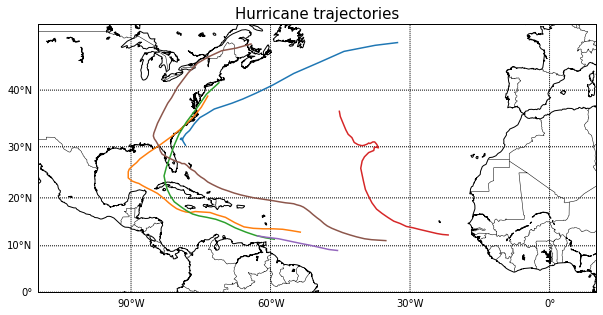

In [4]:
from mpl_toolkits.basemap import Basemap

plt.figure(figsize=(10,5))
m = Basemap(llcrnrlon=-110.,llcrnrlat=0.,urcrnrlon=10.,urcrnrlat=50.,
            rsphere=(6378137.00,6356752.3142),
            resolution='l',
            projection='merc',
            lat_0=40.,lon_0=-20.,lat_ts=20.)
m.drawcoastlines()
m.drawcountries()
m.drawmapboundary()
m.drawparallels(np.arange(-90,90,10),labels=[1,0,0,0])
m.drawmeridians(np.arange(-180,180,30),labels=[0,0,0,1])

#drawing first 5 hurricanes in the dataset
for i in range(len(ID)):
    if i <= 5:
        lat, long = df[df['ID']==ID[i]]['Latitude'], df[df['ID']==ID[i]]['Longitude']
        xpt, ypt = m(np.array(long), np.array(lat))
        m.plot(xpt, ypt)
    else:
        break

plt.title('Hurricane trajectories', fontsize=15)
plt.show()

In [5]:
def is_real_and_finite(x):
    if not np.isreal(x):
        return False
    elif not np.isfinite(x):
        return False
    else:
        return True

#chekcing if values are finite
all_data = df.drop(['ID','Name','Date','Time','Event'], axis=1).values 
numeric_map = df[df.columns[1:]].applymap(is_real_and_finite)
X = np.array(df.drop(['Name','Date','Time','Event','Latitude','Longitude'], axis=1).values)
y = df[df.columns[6:8]] #outputs (hurricane location, latitude and longitude)
print(X.shape, y.shape)

(5921, 16) (5921, 2)


In [6]:
x_columns = df.drop(['Name','Date','Time','Event','Latitude','Longitude'], axis=1)
x_string = [str(name) for name in x_columns.columns[1:]]
print(x_string)

['Status', 'Maximum Wind', 'Minimum Pressure', 'Low Wind NE', 'Low Wind SE', 'Low Wind SW', 'Low Wind NW', 'Moderate Wind NE', 'Moderate Wind SE', 'Moderate Wind SW', 'Moderate Wind NW', 'High Wind NE', 'High Wind SE', 'High Wind SW', 'High Wind NW']


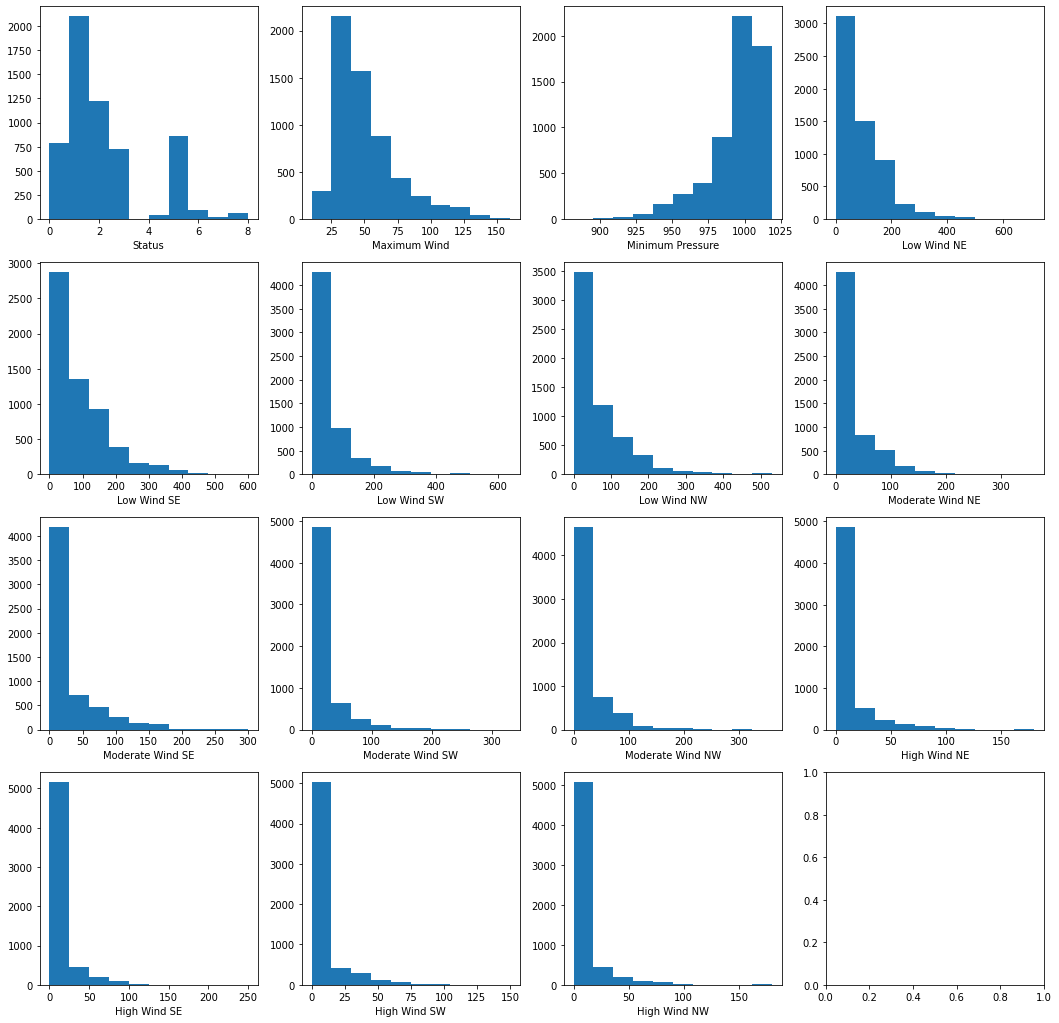

In [7]:
#visualizing the features
N = len(x_string)
n = int(np.sqrt(N))
fig, axes = plt.subplots(n+1, n+1, figsize=(6*n, 6*n))
ax = axes.ravel()
for i in range(N):
    ax[i].hist(X[:,i+1])
    ax[i].set_xlabel(x_string[i])

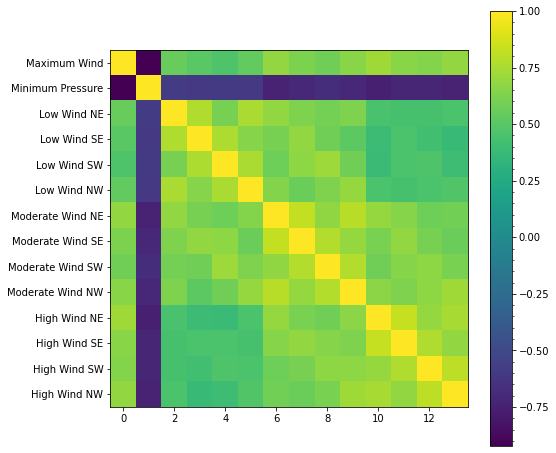

In [8]:
#check correlation numerical features

Xs = X[:,2:].astype(np.float) #ID might be useful later when training the model. But here ID will not be considered. Status is another output we might predict later.
X_scaled = (Xs-Xs.mean(axis=0))/Xs.std(axis=0)
co_var = np.cov(X_scaled.T)

fig, ax = plt.subplots(figsize=(8,8))
ax.set_yticks(np.arange(len(x_string)-1))
ax.set_yticklabels(x_string[1:])
c = ax.imshow(co_var)
cbar = fig.colorbar(c)
cbar.minorticks_on();

[0.65494979 0.10970193 0.04386336 0.03875538 0.03538911 0.02778715
 0.02418346 0.01583164 0.01361641 0.01101179]


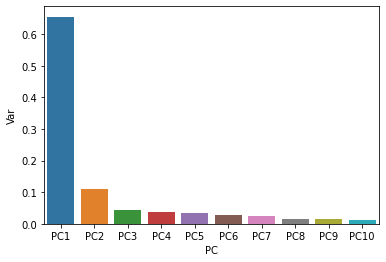

In [9]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns

Xs = StandardScaler().fit_transform(Xs)
pca = PCA(n_components=10)
pc = pca.fit_transform(Xs)

pc_df = pd.DataFrame(data = pc)
print(pca.explained_variance_ratio_)
pca_df = pd.DataFrame({'Var':pca.explained_variance_ratio_, 'PC':['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10']})

sns.barplot(x='PC', y='Var', data=pca_df)

- PC1 explains more than 60% of the variance in the data

In [10]:
#number of components to capture 0.9 variance

pca = PCA(0.9)
pca.fit(Xs)

PCA(copy=True, iterated_power='auto', n_components=0.9, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

print('number of PCs to keep:',pca.n_components_)

number of PCs to keep: 6


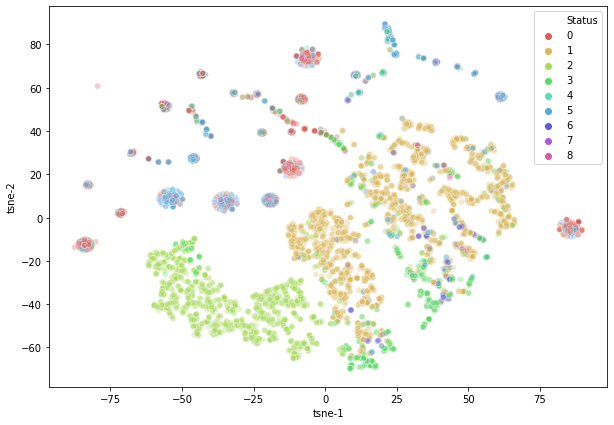

In [11]:
### visualizing data set related to the Status using t-sne with PCs = 6 ###

from sklearn.manifold import TSNE

pca = PCA(n_components=6)
pc = pca.fit_transform(Xs)
tsne = TSNE(n_components=2).fit_transform(pc)
y_status = np.array(df.iloc[:,5])

df['tsne-1']=tsne[:,0]
df['tsne-2']=tsne[:,1]

fig, ax = plt.subplots(figsize=(10,7))
sns.scatterplot(x='tsne-1', y='tsne-2', hue=df['Status'], palette=sns.color_palette("hls",9), data=df.iloc[:,8:], legend='full', alpha=0.3)

In [13]:
### classifying the Status with K-nearest neighbor ###

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
import time
np.random.seed(0)

y_status = np.array(df['Status'])
X_train, X_test, y_train, y_test = train_test_split(X[:,2:], y_status, test_size=0.3)

pca.fit(X_train, y_train)

knnscore = 0
time_start = time.time()

for i in range(3,20):
    knn = KNeighborsClassifier(n_neighbors = i)

    knn.fit(pca.transform(X_train), y_train)
    knn_score = knn.score(pca.transform(X_test), y_test)
    
    if knn_score > knnscore:
        knnscore = knn_score
        a = i
        
print("Optimal K:{}".format(a))
print("KNN score:{}".format(knnscore))
print("KNN time elapsed:{}".format(time.time()-time_start))

Optimal K:14
KNN score:0.8086662915025323
KNN time elapsed:1.5099971294403076


In [14]:
### classifying the Status with Support Vector Machine ###

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

time_start = time.time()

sigmas = np.array([1e-3, 1e-2, 1e-1, 1, 10, 100])
gammas = 1. / 2 / sigmas**2

alphas = np.array([1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1])
Cs = 1 / alphas

parameter_ranges = {'C': Cs, 'gamma': gammas}

svc = SVC(kernel = 'rbf')

svc_search = GridSearchCV(svc, parameter_ranges, cv = 3)
svc_search.fit(pca.transform(X_train), y_train)
print("SVM time elapsed:{}".format(time.time()-time_start))
print("Optimum hyperparameters:{}".format(svc_search.best_estimator_))

SVM time elapsed:1858.1499001979828
Optimum hyperparameters:SVC(C=10.0, gamma=5e-05)


In [15]:
best_svc = svc_search.best_estimator_
print("SVM score:{}".format(best_svc.score(pca.transform(X_test), y_test)))

SVM score:0.814856499718627


In [16]:
### classifying the Status with Decision tree ###

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix

time_start = time.time()

tree = DecisionTreeClassifier()
tree.fit(pca.transform(X_train),y_train)

print("Decision Tree score:{}".format(tree.score(pca.transform(X_test), y_test)))
print("Decision Tree time elapsed:{}".format(time.time()-time_start))

Decision Tree score:0.7799662352279122
Decision Tree time elapsed:0.03296303749084473


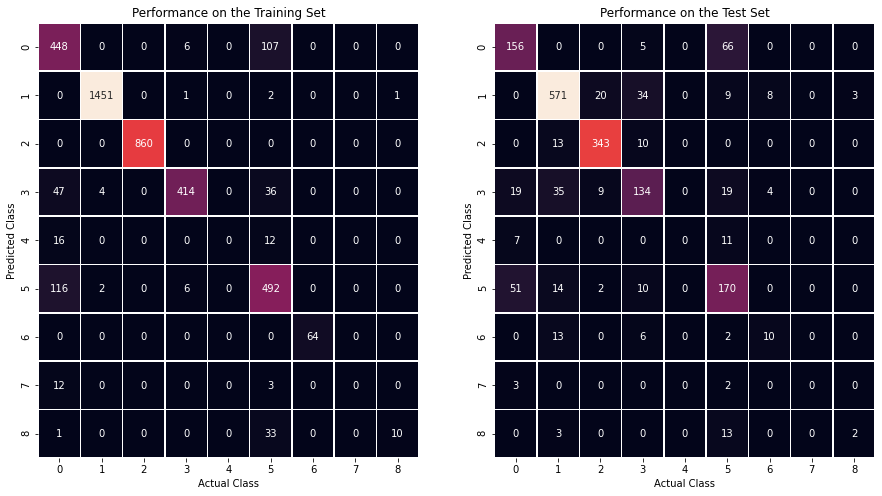

In [17]:
### visualizing the performace of decision tree ###
y_trainpredict = tree.predict(pca.transform(X_train))
heatmap_train = confusion_matrix(y_train, y_trainpredict)

y_testpredict = tree.predict(pca.transform(X_test))
heatmap_test = confusion_matrix(y_test, y_testpredict)

fig, axes = plt.subplots(1, 2, figsize = (15, 8))
sns.heatmap(heatmap_train, annot = True, cbar = False, linewidth = .5, ax = axes[0], fmt = 'd')
sns.heatmap(heatmap_test, annot = True, cbar = False, linewidth = .5, ax = axes[1], fmt = 'd')

axes[0].set_xlabel('Actual Class')
axes[0].set_ylabel('Predicted Class')
axes[0].set_title('Performance on the Training Set')

axes[1].set_xlabel('Actual Class')
axes[1].set_ylabel('Predicted Class')
axes[1].set_title('Performance on the Test Set');

In [18]:
### classifying the Status with Guassian Naive Bayes ###

from sklearn.naive_bayes import GaussianNB

time_start = time.time()

NB = GaussianNB()
NB.fit(pca.transform(X_train), y_train)
NB_score = NB.score(pca.transform(X_test), y_test)

print("Gaussian NB score:{}".format(NB_score))
print("Gaussian NB time elapsed:{}".format(time.time()-time_start))

Gaussian NB score:0.5790658413055711
Gaussian NB time elapsed:0.008990049362182617


### Classification conclusion

- All the classification algorithms resulted decent score (close to 80%) except Gaussian Naive Bayes method.

- SVM with gridserach takes significant amount of time. The score is slightly higher but not significantly different. It is reasonable to use KNN.

## If you guys are trying to use the data set, use X as the input and y as output.

In [19]:
X[:,2:]

array([[25, 1010, 0, ..., 0, 0, 0],
       [25, 1009, 0, ..., 0, 0, 0],
       [25, 1009, 0, ..., 0, 0, 0],
       ...,
       [50, 985, 540, ..., 0, 0, 0],
       [45, 985, 620, ..., 0, 0, 0],
       [45, 987, 710, ..., 0, 0, 0]], dtype=object)

In [20]:
np.array(y)

array([['30.3', -78.3],
       ['31.0', -78.8],
       ['31.5', -79.0],
       ...,
       ['41.5', -49.2],
       ['40.8', -47.5],
       ['40.7', -45.4]], dtype=object)